# Importing Libraries

In [1]:
import os
import re
import pandas as pd
import math
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, SimpleRNN
import keras_tuner

## Cleaning & Splitting the dataset --> to be replaced with standardized data file

In [21]:
news_final = pd.read_csv("news_final.csv")

target = news_final['fake']
features = news_final.drop('fake', axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.25) # 0.25 x 0.8 = 0.2, #20% valid

# Hypothesis 2: Testing Neural Network models

## Define Tokenizing, Padding, Plotting functions & Earlystopping

In [76]:
def tokenize(train_data,val_data,test_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data)

    train_data = tokenizer.texts_to_sequences(train_data)
    val_data = tokenizer.texts_to_sequences(val_data)
    test_data = tokenizer.texts_to_sequences(test_data)
    vocab = tokenizer.word_index
    return train_data,val_data,test_data,vocab

def pad(train_data,val_data,test_data,max_len):
    train_data = pad_sequences(train_data, padding='post', maxlen=max_len)
    val_data = pad_sequences(val_data, padding='post', maxlen=max_len)
    test_data = pad_sequences(test_data, padding='post', maxlen=max_len)
    return train_data,val_data,test_data

def plotHistory(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = history.epoch

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

## Training on titles only

In [77]:
X_train_title,X_val_title,X_test_title,vocab_title = tokenize(X_train['title'],X_val['title'],X_test['title'])
max_vocab_title = len(vocab_title) + 1 # Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
print("Vocab Size for Titles: {}".format(max_vocab_title))

# get length of longest title and pad all shorter titles to match length
max_len_title = max([len(x) for x in X_train_title] + [len(x) for x in X_test_title])
X_train_title,X_val_title,X_test_title = pad(X_train_title,X_val_title,X_test_title,max_len_title)
print("Max Title Length: {}".format(max_len_title))

### Training a simple RNN model on titles only

In [78]:
rnn_title_model = Sequential([
    Embedding(max_vocab_title, 100, input_length=max_len_title),
    Bidirectional(SimpleRNN(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_title_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

rnn_title_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 52, 100)           1729200   
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              58624     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,788,081
Trainable params: 1,788,081
Non-trainable params: 0
_________________________________________________________________


In [80]:
%%time
rnn_title_history = rnn_title_model.fit(X_train_title, y_train, epochs=10, 
                    validation_data=(X_val_title, y_val), batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
783/783 [==============================] - 125s 158ms/step - loss: 0.1900 - accuracy: 0.9283 - val_loss: 0.1130 - val_accuracy: 0.9605
Epoch 2/10
783/783 [==============================] - 120s 153ms/step - loss: 0.0655 - accuracy: 0.9801 - val_loss: 0.0895 - val_accuracy: 0.9702
Epoch 3/10
783/783 [==============================] - 120s 153ms/step - loss: 0.0351 - accuracy: 0.9902 - val_loss: 0.0892 - val_accuracy: 0.9723
Epoch 4/10
783/783 [==============================] - 122s 156ms/step - loss: 0.0237 - accuracy: 0.9935 - val_loss: 0.1007 - val_accuracy: 0.9693
Epoch 5/10
783/783 [==============================] - 122s 155ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.1155 - val_accuracy: 0.9677
CPU times: total: 14min 36s
Wall time: 10min 8s


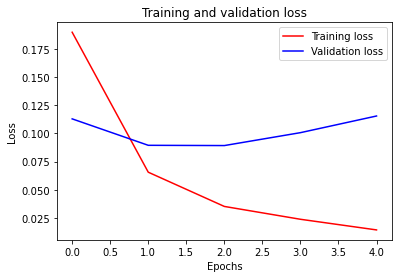

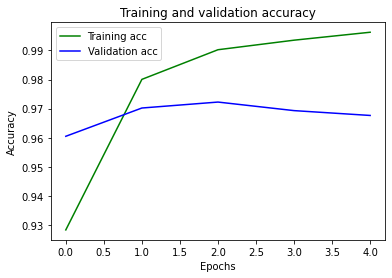

In [81]:
plotHistory(rnn_title_history)

In [82]:
rnn_title_model.evaluate(X_train_title, y_train)

734/734 [==============================] - 15s 21ms/step - loss: 0.0162 - accuracy: 0.9964


[0.016225943341851234, 0.9963772892951965]

In [83]:
rnn_title_model.evaluate(X_val_title, y_val)

245/245 [==============================] - 5s 22ms/step - loss: 0.0892 - accuracy: 0.9723


[0.08923334628343582, 0.97225421667099]

In [84]:
rnn_title_model.evaluate(X_test_title, y_test)

245/245 [==============================] - 6s 24ms/step - loss: 0.0810 - accuracy: 0.9729


[0.08097951859235764, 0.972893476486206]

### Training an LSTM model on titles only

In [ ]:
lstm_title_model = Sequential([
    Embedding(max_vocab_title, 100, input_length=max_len_title),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_title_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

lstm_title_model.summary()

In [ ]:
%%time
lstm_title_history = rnn_title_model.fit(X_train_title, y_train, epochs=10, 
                    validation_data=(X_val_title, y_val), batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

In [ ]:
plotHistory(lstm_title_history)

In [ ]:
lstm_title_model.evaluate(X_train_title, y_train)

In [ ]:
lstm_title_model.evaluate(X_val_title, y_val)

In [ ]:
lstm_title_model.evaluate(X_test_title, y_test)

## Training on all text (title + text)

### Training the word2vec model on the dataset

<li>There are certain characteristics distinct to fake news that would be helpful for prediction (eg. number of capitalised words, punctuations etc. However, since word2vec trains better on words in their raw form, we will preprocess the text for this purpose while extracting the distinctive characteristics and train them in another classification model.</li>
<li>Since the use of language and choice of vocabulary differs between real and fake news, we will not lemmatise/stem the words in our corpus</li>


In [85]:
# # only words (can have - or ') will be generated as tokens
# create a list of elements each containing a list of words from each article in the corpus
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize

def corpus_to_vect(df_column):
    corpus_tokens = []
    stop_words = set(stopwords.words("english"))
    rtokenizer = RegexpTokenizer(r'[a-zA-Z\'\-]+') # matches any word that contains only letters, hyphens, and apostrophes
    docs = df_column.values
    for doc in docs:
        sents = sent_tokenize(doc)
        doc_tokens = []
        for sent in sents:
            sent_lowered = sent.lower()
            words = rtokenizer.tokenize(sent_lowered) # convert all words to lower case
            filtered = [word.strip() for word in words if word not in stop_words and len(word) > 1] # filter out stopwords
            doc_tokens.extend(filtered)
        corpus_tokens.append(doc_tokens)
    return corpus_tokens

In [86]:
# tokenizing the 'text' column 
X_train_alltext = corpus_to_vect(X_train['all_text'])
X_val_alltext = corpus_to_vect(X_val['all_text'])
X_test_alltext = corpus_to_vect(X_test['all_text'])

In [87]:
 # all tokens generated in the first article
print(X_train_alltext[0])

['trump', 'meet', 'wilbur', 'ross', 'possible', 'choice', 'commerce', 'secretary', 'president', 'elect', 'donald', 'trump', 'meet', 'sunday', 'billionaire', 'investor', 'wilbur', 'ross', 'possible', 'candidate', 'commerce', 'secretary', 'new', 'administration', 'spokesman', 'trump', 'transition', 'team', 'said', 'saturday', 'trump', 'takes', 'office', 'jan', 'also', 'meet', 'others', 'sunday', 'including', 'new', 'jersey', 'governor', 'chris', 'christie', 'former', 'new', 'york', 'mayor', 'rudy', 'giuliani', 'kris', 'kobach', 'kansas', 'secretary', 'state', 'architect', 'anti', 'immigration', 'efforts', 'says', 'advising', 'trump', 'immigration', 'issues', 'trump', 'transition', 'team', 'official', 'said', 'senior', 'appointment', 'could', 'announced', 'soon']


In [88]:
# training word2vec on the 'text' corpus to form the embedding layer
from gensim.models import Word2Vec

EMBEDDING_DIM = 100
w2v = Word2Vec(
    sentences = X_train_alltext,
    vector_size = EMBEDDING_DIM,
    window = 5,
    min_count = 1
)

In [89]:
num = len(w2v.wv)
print('There are a total of %d words in the vocabulary of our trained word2vec model.' % num)

There are a total of 90465 words in the vocabulary of our trained word2vec model.


In [90]:
w2v.wv["donald"]

array([ 1.1552894 , -0.5198847 ,  1.0302882 , -3.6223907 , -0.2048854 ,
       -0.28337118,  0.3356402 , -2.844938  ,  0.10124575, -1.441538  ,
        3.593388  , -1.0334003 ,  1.425214  , -1.0650119 ,  1.2551752 ,
        1.8217119 ,  0.7099602 , -0.58810145,  1.6516346 , -0.4033152 ,
       -0.81854945, -1.1924291 ,  1.8974582 , -1.7437774 ,  1.9729719 ,
        2.4017272 , -1.0348462 , -1.637253  ,  3.4399722 ,  1.9604932 ,
       -1.7860178 , -0.535136  ,  1.883963  ,  0.5586981 ,  1.6199689 ,
        1.8988328 ,  0.6566153 , -0.03721009, -0.16817667, -0.2910872 ,
        0.22612746, -1.0175784 , -1.5149072 ,  2.3982847 , -0.7469167 ,
       -2.447297  , -1.9995306 ,  0.32351092, -1.4016461 , -0.10110394,
        1.0389899 , -1.4136665 , -0.8776653 ,  3.930473  ,  1.6284257 ,
       -1.763769  , -3.1475923 ,  2.2891166 ,  0.20814092, -3.8586402 ,
        0.07189158, -1.1412206 , -1.9838977 ,  1.5410899 , -1.3529675 ,
        1.1406834 , -1.4314263 ,  0.25854883,  1.0665526 , -2.37

In [91]:
w2v.wv.most_similar("trump")

[('elect', 0.6679061651229858),
 ('course', 0.5462140440940857),
 ('conway', 0.517255425453186),
 ('bush', 0.489884614944458),
 ('actually', 0.4863853454589844),
 ('proving', 0.4714583456516266),
 ('however', 0.46439361572265625),
 ('completely', 0.46291571855545044),
 ('temperment', 0.4586942493915558),
 ('instead', 0.4560230076313019)]

### Preparing the neural network model inputs

In [92]:
X_train_alltext,X_val_alltext,X_test_alltext, vocab_alltext = tokenize(X_train_alltext,X_val_alltext,X_test_alltext)
max_vocab_alltext = len(vocab_alltext) + 1
print("Vocab Size for All Text: {}".format(max_vocab_alltext))

In [93]:
# all token indexes generated from the first article
print(X_train_alltext[0])

[1, 483, 5274, 1956, 327, 933, 1940, 116, 3, 634, 11, 1, 483, 215, 1244, 3514, 5274, 1956, 327, 140, 1940, 116, 8, 60, 242, 1, 904, 344, 2, 381, 1, 963, 75, 1187, 9, 483, 369, 215, 74, 8, 1539, 249, 1165, 1507, 31, 8, 142, 884, 5604, 3142, 8601, 6432, 2304, 116, 7, 9088, 164, 213, 410, 68, 7230, 1, 213, 319, 1, 904, 344, 127, 2, 278, 2783, 18, 503, 718]


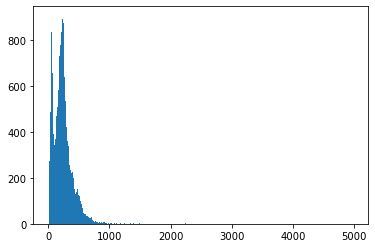

In [94]:
article_lens = np.array([len(index) for index in X_train_alltext])
plt.hist(article_lens, bins=500)
plt.show()

In [95]:
len_1000 = article_lens[article_lens < 1000]
print('%d out of %d articles have less than 1000 words' % (len(len_1000),len(article_lens)))

23361 out of 23463 articles have less than 1000 words


<li>Since the inputs to the neural network have to be of the same size, we have to pad each article in the dataset.</li>
<li>Since the majority of articles have less than 1000 words, we pad shorter news articles and truncate longer articles.</li>

In [96]:
max_len_alltext = 1000
X_train_alltext,X_val_alltext,X_test_alltext = pad(X_train_alltext,X_val_alltext,X_test_alltext,max_len_alltext)
print("Max All Text Length: {}".format(max_len_alltext))

In [97]:
# creating a weight matrix to retain weights learned by word2vec in the embedding layer later on
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # create weight matrix with number of rows = vocab_size and number of columns = number of embedding dimensions
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # for each word in the vocab, store its vector created by the word2vec model
    for word, row_index in vocab.items():
        weight_matrix[row_index] = model.wv[word]
    return weight_matrix

In [98]:
embedding_vectors = get_weight_matrix(w2v, vocab_alltext)

### Training a simple RNN model on all text

In [ ]:
rnn_alltext_model = Sequential([
    Embedding(max_vocab_alltext, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len_alltext, trainable=False),
    Bidirectional(SimpleRNN(units=128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_alltext_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

rnn_alltext_model.summary()

In [ ]:
%%time
rnn_alltext_history = lstm_model.fit(X_train_alltext, y_train, epochs=10, 
                                validation_data=(X_val_alltext, y_val), batch_size=30, 
                                shuffle=True, callbacks=[early_stop])

In [ ]:
plotHistory(rnn_alltext_history)

In [ ]:
rnn_alltext_model.evaluate(X_train_alltext, y_train)

In [ ]:
rnn_alltext_model.evaluate(X_val_alltext, y_val)

In [ ]:
rnn_alltext_model.evaluate(X_test_alltext, y_test)

### Training an LSTM model on all text

In [99]:
lstm_alltext_model = Sequential([
    Embedding(max_vocab_alltext, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len_alltext, trainable=False),
    Bidirectional(LSTM(units=128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_alltext_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

lstm_alltext_model.summary()

In [102]:
%%time
lstm_alltext_history = lstm_model.fit(X_train_alltext, y_train, epochs=10, 
                                validation_data=(X_val_alltext, y_val), batch_size=30, 
                                shuffle=True, callbacks=[early_stop])

Epoch 1/10
783/783 [==============================] - 69s 84ms/step - loss: 0.1904 - accuracy: 0.9286 - val_loss: 0.1010 - val_accuracy: 0.9657
Epoch 2/10
783/783 [==============================] - 65s 83ms/step - loss: 0.0879 - accuracy: 0.9700 - val_loss: 0.0742 - val_accuracy: 0.9753
Epoch 3/10
783/783 [==============================] - 66s 85ms/step - loss: 0.0672 - accuracy: 0.9772 - val_loss: 0.0617 - val_accuracy: 0.9784
Epoch 4/10
783/783 [==============================] - 63s 80ms/step - loss: 0.0590 - accuracy: 0.9798 - val_loss: 0.0555 - val_accuracy: 0.9808
Epoch 5/10
783/783 [==============================] - 63s 80ms/step - loss: 0.0485 - accuracy: 0.9843 - val_loss: 0.0490 - val_accuracy: 0.9829
Epoch 6/10
783/783 [==============================] - 63s 80ms/step - loss: 0.0420 - accuracy: 0.9863 - val_loss: 0.0476 - val_accuracy: 0.9834
Epoch 7/10
783/783 [==============================] - 63s 81ms/step - loss: 0.0419 - accuracy: 0.9867 - val_loss: 0.0473 - val_accuracy:

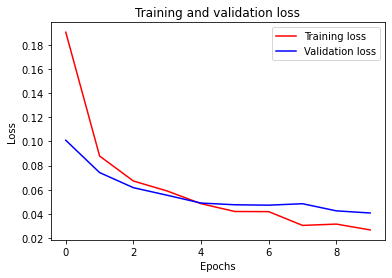

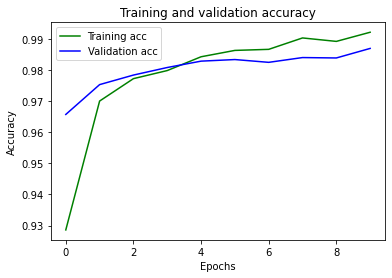

In [103]:
plotHistory(lstm_alltext_history)

In [104]:
lstm_alltext_model.evaluate(X_train_alltext, y_train)

734/734 [==============================] - 29s 39ms/step - loss: 0.0191 - accuracy: 0.9943


[0.01908102259039879, 0.9943314790725708]

In [105]:
lstm_alltext_model.evaluate(X_val_alltext, y_val)

245/245 [==============================] - 10s 40ms/step - loss: 0.0408 - accuracy: 0.9870


[0.0407821387052536, 0.9869582056999207]

In [106]:
lstm_alltext_model.evaluate(X_test_alltext, y_test)

245/245 [==============================] - 10s 39ms/step - loss: 0.0428 - accuracy: 0.9873


[0.04282530024647713, 0.9873417615890503]

### Hyperparameter tuning for LSTM model for all text

In [143]:
def hyperparameterTuning(hp): #https://keras.io/api/keras_tuner/hyperparameters/
    model = Sequential([
        Embedding(max_vocab_alltext, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len_alltext, trainable=False),
        Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=192, step=64))), #https://keras.io/api/layers/recurrent_layers/simple_rnn/
        Dropout(rate=hp.Float('rate', min_value=0.3, max_value=0.7, step=0.2)), #https://keras.io/api/layers/regularization_layers/dropout/
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    return model

In [145]:
#https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
tuner = keras_tuner.BayesianOptimization(hyperparameterTuning,
                              objective='val_loss',
                             directory='lstm_tuner2')

In [146]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
tuner.search(X_train_alltext, y_train, epochs=10, 
            validation_data=(X_val_alltext, y_val), batch_size=30, 
            shuffle=True, callbacks=[early_stop])

Trial 10 Complete [00h 14m 26s]
val_loss: 0.04192085936665535

Best val_loss So Far: 0.03331878408789635
Total elapsed time: 02h 19m 24s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [147]:
tuner.results_summary()

Results summary
Results in lstm_tuner2\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
rate: 0.7
Score: 0.03331878408789635
Trial summary
Hyperparameters:
units: 192
rate: 0.7
Score: 0.039939410984516144
Trial summary
Hyperparameters:
units: 128
rate: 0.5
Score: 0.041870806366205215
Trial summary
Hyperparameters:
units: 128
rate: 0.5
Score: 0.04192085936665535
Trial summary
Hyperparameters:
units: 128
rate: 0.7
Score: 0.04503205046057701
Trial summary
Hyperparameters:
units: 192
rate: 0.5
Score: 0.04686621576547623
Trial summary
Hyperparameters:
units: 64
rate: 0.3
Score: 0.04874274879693985
Trial summary
Hyperparameters:
units: 192
rate: 0.3
Score: 0.05330261215567589
Trial summary
Hyperparameters:
units: 64
rate: 0.7
Score: 0.05358147248625755
Trial summary
Hyperparameters:
units: 192
rate: 0.7
Score: 0.05900872126221657


In [148]:
best_lstm_model = tuner.get_best_models(num_models=1)[0]

In [149]:
best_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         9046600   
                                                                 
 bidirectional (Bidirectiona  (None, 384)              450048    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 1)                 385       
                                                                 
Total params: 9,497,033
Trainable params: 450,433
Non-trainable params: 9,046,600
_________________________________________________________________


In [150]:
best_lstm_model.evaluate(X_train_alltext, y_train)

734/734 [==============================] - 31s 41ms/step - loss: 0.0210 - accuracy: 0.9932


[0.02104427106678486, 0.9932233691215515]

In [151]:
best_lstm_model.evaluate(X_val_alltext, y_val)

245/245 [==============================] - 10s 40ms/step - loss: 0.0333 - accuracy: 0.9890


[0.03331877291202545, 0.9890039563179016]

In [152]:
best_lstm_model.evaluate(X_test_alltext, y_test)

245/245 [==============================] - 10s 40ms/step - loss: 0.0442 - accuracy: 0.9873


[0.04415591061115265, 0.9873417615890503]